In [115]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.nn.init import kaiming_uniform_

In [116]:
import numpy as np
import gym
from tqdm import tqdm
import random as rand
from itertools import count

In [117]:
env = gym.make("CartPole-v0")

In [118]:
class ReplayMemory():
    def __init__(self,capacity):   
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count%self.capacity] = experience
        self.push_count+=1
    
    def sample(self, batch_size):
        return rand.sample(self.memory,batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory)>=batch_size
    
    def update_td_error(self, sampled_experiences):
        for sampled_idx,sampled_exp in enumerate(sampled_experiences):
            for mem_idx, mem_exp in enumerate(self.memory):
                if mem_exp.timestep == sampled_exp.timestep:
                    self.memory[mem_idx] = sampled_exp #update memory
                    break
        
    def get_memory_values(self):
        return self.memory    

In [119]:
def extract_tensors(experiences):
    #print(".....................................................")
    #print(experiences)
    batch = Xp(*zip(*experiences))
    state = np.stack(batch.state) #stack
    action = np.stack(batch.action)
    next_state = np.stack(batch.next_state)
    reward = np.stack(batch.reward)
    done = np.stack(batch.done)
    abs_td_error = np.stack(batch.abs_td_error)
    timestep = np.stack(batch.timestep)
    return state,action,next_state,reward,done,abs_td_error,timestep

In [120]:
def rebuild_experiences(state, action, next_state, reward, done, abs_error, timestep):
    exp_list = []
    for idx_ in range(len(state)):
        exp_list.append(\
                        Xp(state[idx_], action[idx_], next_state[idx_], reward[idx_],\
                           done[idx_], abs_error[idx_], timestep[idx_]))
    return exp_list

In [121]:
from collections import namedtuple
Xp = namedtuple('Experience',
                        ('state', 'action', 'next_state', 'reward', 'done', 'abs_td_error','timestep'))
Xp_points = Xp(5,6,7,8,9,10,11)
Xp_points

Experience(state=5, action=6, next_state=7, reward=8, done=9, abs_td_error=10, timestep=11)

In [122]:
class linearApproximator(nn.Module):
    def __init__(self,state_shape,n_fc1,n_fc2, action_n):
        super(linearApproximator, self).__init__()
        self.input_size = state_shape
        self.n_fc1 = n_fc1
        self.n_fc2 = n_fc2
        self.out = action_n
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.fc1  = nn.Linear(self.input_size,self.n_fc1)
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.fc2  = nn.Linear(self.n_fc1,self.n_fc2)
        kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        
        self.state_value = nn.Linear(self.n_fc2, 1)
        kaiming_uniform_(self.state_value.weight, nonlinearity='relu')
        self.advantage_actions  = nn.Linear(self.n_fc2,self.out)
        kaiming_uniform_(self.advantage_actions.weight, nonlinearity='relu')
        
        
        self.to(self.device)
        
    def forward(self, state_shape):
        x = self.fc1(state_shape)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        
        
        actions_ = self.advantage_actions(x)
        actions_ = F.relu(actions_)
        state_value_=self.state_value(x)
        state_value_=F.relu(state_value_)
        state_value_ = state_value_.expand_as(actions_)
        #adabantage function equation pg:311 - 316
        q = state_value_ + (actions_ - actions_.mean().expand_as(actions_))
        return q

In [123]:
def update_networks(online_network, target_network, tau):
    #polyak averaging: pg:319
    for target_weights, online_weights in zip(target_network.parameters(), online_network.parameters()):
        target_weight_update = (1.0 - tau)*target_weights.data
        online_weight_update = tau*online_weights.data
        sum_up = target_weight_update + online_weight_update
        target_weights.data.copy_(sum_up)
    return online_network, target_network

In [124]:
def update_online_model(experience_samples, online_network, target_network, gamma, optimizer,\
                        weighted_importance, indices):
    states, actions, next_states, rewards, done, td_errors, timesteps = extract_tensors(experience_samples)
    
    
    
    #rearrange first
    indices = np.array(indices)#have to be same size as batch size(already taken care of)
    indices = np.squeeze(indices)
    
    states = states[indices,:]
    states = np.squeeze(states)
    
    next_states = next_states[indices,:]
    next_states = np.squeeze(next_states)
    
    actions = actions[indices]
    rewards = rewards[indices]
    done = done[indices]
    td_errors = td_errors[indices]
    timesteps = timesteps[indices]    
    
    
    
    
    states = torch.tensor(states).float()
    actions = torch.tensor(actions)
    actions = actions.type(torch.LongTensor)
    actions = actions.unsqueeze(1)
    next_states=torch.tensor(next_states).float()
    rewards = torch.tensor(rewards).float()
    rewards = rewards.unsqueeze(1)
    done = torch.tensor(done).float()
    done = done.unsqueeze(1)
    weighted_importance = torch.tensor(weighted_importance).float()
    
    q_online_next_states = online_network(next_states)#we now take next_states from online network 
    q_online_next_states = q_online_next_states.max(1)[1]#we now take the indices and not the values from online network
    q_online_next_states = q_online_next_states.unsqueeze(1)#iindices
     
    
    q_target_next_states_action = target_network(next_states)
    q_target_next_states_action = q_target_next_states_action.detach()#always make sure detach on target net
    q_target_next_states_action = q_target_next_states_action.gather(1, q_online_next_states)
    #print(q_target_next_states_action.shape)
    
    
    #print(q_target_next_states_action.shape, done.shape)
    
    q_target_next_states_action *=(1 - done) 
    
    q_target = rewards + (gamma*q_target_next_states_action)
    
    
    q_online_state = online_network(states)
    q_online_state = q_online_state.gather(1, actions)
    
    q_online_state*= weighted_importance
    q_target*=weighted_importance
    
    abs_error = abs(q_online_state - q_target)#update experience errors
    
    q_u_loss = torch.nn.SmoothL1Loss()
    q_u_loss = q_u_loss(q_online_state,q_target)
    
    optimizer.zero_grad()
    q_u_loss.backward()
    optimizer.step()
    
    states, actions, next_states, rewards, done, td_errors, timesteps = extract_tensors(experience_samples)
    abs_error = abs_error.detach().cpu().numpy()
    abs_error = np.squeeze(abs_error)
    #print(abs_error.shape, " abs error shape")
    #print(td_errors.shape, "td errors shape")
    experiences_rebuilded = rebuild_experiences(states, actions, next_states, rewards, done, abs_error, timesteps)
    return online_network, target_network, experiences_rebuilded

In [125]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
    return model

In [126]:
def select_action(state, model, epsilon):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    state = torch.tensor(state).float()
    with torch.no_grad():
        q_values= model(state).cpu().detach()
        q_values = q_values.data.numpy().squeeze()
    if np.random.rand() > epsilon:
        action = np.argmax(q_values)
    else:
        action = np.random.randint(len(q_values))
    return action

In [127]:
def epsilon_decay_linear(init_eps, min_eps, decay_ratio, timestep, timestep_max):
    decay_t_step = timestep_max*decay_ratio
    epsilon = 1 - timestep/decay_t_step
    epsilon *= init_eps-min_eps
    epsilon+=min_eps
    epsilon = np.clip(epsilon, min_eps, init_eps)
    return epsilon

In [128]:
def query_error(online_model, target_model, state, next_state):
    state = torch.tensor(state).float()
    next_state = torch.tensor(next_state).float()
    q_val = online_model(state)
    q_val = q_val.unsqueeze(0)
    q_val = q_val.detach().cpu().numpy()#detatch
    q_val = q_val.max(1)[0]#take values of max
    q_val_nxt = target_model(next_state)
    q_val_nxt = q_val_nxt.unsqueeze(0)
    q_val_nxt = q_val_nxt.detach().cpu().numpy()#detach
    q_val_nxt = q_val_nxt.max(1)[0]#
    return q_val, q_val_nxt

In [129]:
def prioritize_samples(experience_samples, alpha, beta):
    state,action,next_state,reward,done,abs_td_error,timesteps = extract_tensors(experience_samples)
    #rank based
    #('state', 'action', 'next_state', 'reward', 'done', 'abs_td_error','timestep')
    abs_td_error  = np.expand_dims(abs_td_error, axis=1)
    abs_td_error = torch.tensor(abs_td_error)
    abs_td_error, indices_ = abs_td_error.sort(0, descending=True)#big to small
    indices = np.arange(1, len(abs_td_error)+1)
    priorities = 1.0/indices
    priorities = priorities**alpha#scale by alpha
    priorities = np.expand_dims(priorities, axis=1)
    probabilities = priorities/np.sum(priorities, axis=0)#sums up to 1(or 0.999999)
    assert np.isclose(probabilities.sum(), 1.0)#ensures probs add up to 1
    
    number_of_samples  = len(probabilities)
    weight_importance_ = number_of_samples*probabilities
    weight_importance_ = weight_importance_**-beta
    weight_importance_max = np.max(weight_importance_)
    weight_importance_scaled = weight_importance_/weight_importance_max
    return weight_importance_scaled, indices_ #return weight important samples, return indices for re_arranging sampled experiences

In [132]:
def Duelling_DDQN_PER(env,
         gamma=0.99,
         alpha_pr=0.6,
         beta_pr=0.3,
         memory_size = 50000,
         init_epsilon=1.0,
         min_epsilon=0.3,
         epsilon_decay_ratio=0.01,
         tau = 0.001,
         target_update = 100,
         min_sample_size=320,
         batch_size = 64,
         n_ep=1000,
         max_t_steps = 10000):
    
    action_space = env.action_space.n
    observation_space = len(env.reset())
    hidden_1 = 512
    hidden_2 = 128
    
    online_network = linearApproximator(observation_space, hidden_1, hidden_2, action_space)
    target_network = linearApproximator(observation_space, hidden_1, hidden_2, action_space)
    target_network.eval()
    target_network = freeze_model(target_network)
    
    optimizer = torch.optim.RMSprop(online_network.parameters(),lr=0.0007)
    memory = ReplayMemory(memory_size)
    
    t_step = 0 #important
    reward_per_ep = []
    
    for e in tqdm(range(n_ep)):
        state = env.reset()
        reward_accumulated = 0
        while True:
            epsilon = epsilon_decay_linear(init_epsilon, min_epsilon, epsilon_decay_ratio, t_step, max_t_steps)
            action = select_action(state, online_network, epsilon)
            
            next_state, reward, done, info = env.step(action)
            
            q_state_a, q_next_state_a = query_error(online_network, target_network, state, next_state)
            #convert them to numpy
            #calculate shock value and append error to replay memory for PER analysis
            td_target = reward + gamma*q_next_state_a
            td_error = abs(td_target - q_state_a)#shock value
            
            reward_accumulated+=reward
            is_truncated = 'TimeLimit.truncated' in info and\
                                info['TimeLimit.truncated']
            is_failure = done and not is_truncated
           
            memory.push(Xp(state, action, next_state, reward, is_failure, td_error, t_step))
            state = next_state
            t_step+=1
            if memory.can_provide_sample(min_sample_size):
                #we only update td_errors for samples used to update the network - meaning batch_size?
                experience_samples = memory.sample(batch_size)
                weighted_importance, indices = prioritize_samples(experience_samples, alpha_pr, beta_pr)
                online_network, target_network, rebuilded_exp = update_online_model(experience_samples, online_network,\
                                                                                    target_network, gamma, optimizer,\
                                                                                    weighted_importance, indices)
                memory.update_td_error(rebuilded_exp)
                
            if t_step%target_update:
                online_network, target_network = update_networks(online_network, target_network, tau)
            if done == True:
                reward_per_ep.append(reward_accumulated)
                #print(reward_accumulated)
                break
            if t_step > max_t_steps:
                return online_network, reward_per_ep
    return reward_per_ep

In [133]:
from random import seed
seed(5)
rewards = Duelling_DDQN_PER(env)

 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [06:00<00:55,  2.40it/s]


In [134]:
#print(rewards)

In [136]:
from scipy.ndimage.filters import uniform_filter1d
arr = uniform_filter1d(rewards[1], size=10)

In [137]:
from matplotlib import pyplot as plt
x = []
y = []
for i,e in enumerate(arr):
    y.append(i)
    x.append(e)

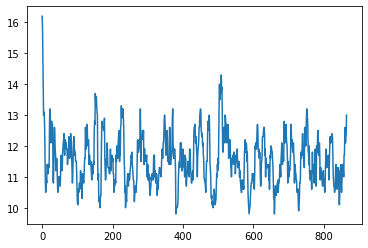

In [138]:
plt.plot(y, x)#tau 0.1, t = 10 0.01 decay, corrected, added min_sample sixe and batch_size